In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np

In [0]:
from google.colab import drive, files
drive.mount(r'/content/gdrive')

In [3]:
data=pd.read_csv(r'/content/train test data.csv?dl=0')

--2020-05-03 11:29:26--  https://www.dropbox.com/s/qvxz4qnyfb8w3re/train%20test%20data.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qvxz4qnyfb8w3re/train%20test%20data.csv [following]
--2020-05-03 11:29:26--  https://www.dropbox.com/s/raw/qvxz4qnyfb8w3re/train%20test%20data.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f966e519355e0fc79b2814629.dl.dropboxusercontent.com/cd/0/inline/A3CqJ3mC5jpJc7m2qgqju6TFLAjoKCT2RzXcTjyRd4JALTMMufSLxA8NB967crb0hX5MalKa8lUicO1iNsHn7xePwfDbtmJ4-SW3g9Cnjhhk7QoaXfDjB-A4Al1HYat_qpg/file# [following]
--2020-05-03 11:29:26--  https://uc7f966e519355e0fc79b2814629.dl.dropboxusercontent.com/cd/0/inline/A3CqJ3mC5jpJc7m2qgqju6TFLAjoKCT2RzXcTjyRd4JALTMMufSLxA8NB967crb0hX5MalKa8lUi

In [0]:
data=data[~data['Body'].isnull()]


In [6]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import re
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk import WordNetLemmatizer, pos_tag, word_tokenize
lemma = WordNetLemmatizer()
my_stop=set(stopwords.words('english')+list(punctuation))

from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
data['concate']=data[['Subject','Body']].apply(lambda x:' '.join(x.astype(str)),axis=1)
df=data.loc[:,['concate','Class']]

In [0]:
df_train,df_test=train_test_split(df,test_size=0.2,random_state=2)

In [0]:
y_train=(df_train['Class']=='spam').astype(int)
y_train.reset_index(inplace=True,drop=True)
y_test=(df_test['Class']=='spam').astype(int)
y_test.reset_index(inplace=True,drop=True)

In [0]:
df_train.reset_index(inplace=True,drop=True)
df_test.reset_index(inplace=True,drop=True)

In [0]:
my_stop=set(stopwords.words('english')+list(punctuation)+[i for i in '0123456789'])

In [0]:
def lemmatize(text):
    """ Tokenize text and lemmatize word tokens """
    
    text=text.lower()
    def get_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        return wordnet.NOUN
    
    wnl = WordNetLemmatizer()
    num=re.compile(u'(?ui)\\b\\w*[a-z]+\\w*\\b')
    return [wnl.lemmatize(token, get_pos(tag)) for token, tag in pos_tag(word_tokenize(text)) if (token not in my_stop) and (num.search(token)!=None)]

tf=TfidfVectorizer(tokenizer=lemmatize ,min_df=100,max_df=500)

In [0]:
tf.fit(df_train['concate'])
train_tf=tf.transform(df_train['concate'])


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [0]:
x_train_tf=pd.DataFrame(train_tf.toarray(),columns=tf.get_feature_names())
col=x_train_tf.columns

In [0]:
print(x_train_tf.shape,y_train.shape)
print(x_test_tf.shape,y_test.shape)

input_len=x_train_tf.shape[1]
print(input_len,type(input_len))

(26600, 2219) (26600,)
(6651, 2219) (6651,)
2219 <class 'int'>


In [0]:
test_tf=tf.transform(df_test['concate'])
x_test_tf=pd.DataFrame(test_tf.toarray(),columns=tf.get_feature_names())

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, LSTM
from tensorflow.keras import backend as K

from tensorflow.keras.backend import sigmoid
from tensorflow.keras import activations

from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score

In [0]:
model = Sequential()

model.add(Dense(1000,input_dim=input_len,activation='relu'))

model.add(Dropout(0.1))

model.add(Dense(500,activation=LeakyReLU()))

model.add(Dropout(0.1))

model.add(Dense(200,activation='relu'))

model.add(Dropout(0.15))

model.add(Dense(50,activation=LeakyReLU()))

model.add(Dropout(0.1))

model.add(Dense(1,activation='sigmoid'))

In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1000)              2220000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)               

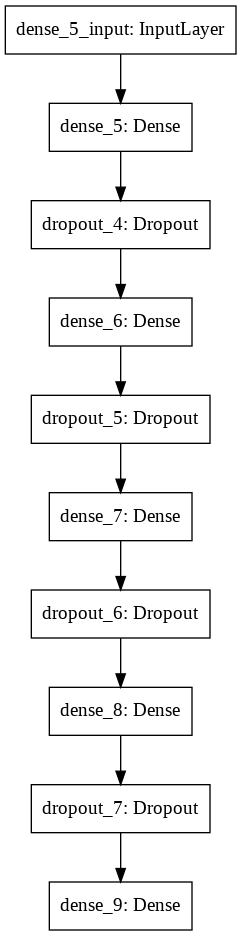

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [0]:
model.fit(x_train_tf,y_train.values,validation_data=(x_test_tf,y_test.values),epochs=100,batch_size=100,verbose=1)

Epoch 1/100
266/266 [==============================] - 1s 5ms/step - loss: 0.1559 - accuracy: 0.9325 - val_loss: 0.1147 - val_accuracy: 0.9505
Epoch 2/100
266/266 [==============================] - 1s 5ms/step - loss: 0.0640 - accuracy: 0.9731 - val_loss: 0.1095 - val_accuracy: 0.9549
Epoch 3/100
266/266 [==============================] - 1s 4ms/step - loss: 0.0375 - accuracy: 0.9830 - val_loss: 0.1466 - val_accuracy: 0.9556
Epoch 4/100
266/266 [==============================] - 1s 4ms/step - loss: 0.0269 - accuracy: 0.9866 - val_loss: 0.2415 - val_accuracy: 0.9553
Epoch 5/100
266/266 [==============================] - 1s 5ms/step - loss: 0.0255 - accuracy: 0.9868 - val_loss: 0.2009 - val_accuracy: 0.9562
Epoch 6/100
266/266 [==============================] - 1s 4ms/step - loss: 0.0275 - accuracy: 0.9858 - val_loss: 0.2383 - val_accuracy: 0.9513
Epoch 7/100
266/266 [==============================] - 1s 4ms/step - loss: 0.0271 - accuracy: 0.9858 - val_loss: 0.2228 - val_accuracy: 0.9535

In [0]:
print('Train Data Accuracy',roc_auc_score(y_train,model.predict(x_train_tf)))

print('Test Data Accuracy',roc_auc_score(y_test,model.predict(x_test_tf)))

Train Data Accuracy 0.9995335688806198
Test Data Accuracy 0.9917166148486698


In [0]:
cutoffs=np.linspace(0.01,0.99,99)
real=y_train
prob_score=model.predict(x_train_tf)

In [0]:
KS_cut=[]
for cutoff in cutoffs:
  predicted=pd.Series([0]*len(y_train))
  predicted=(prob_score>cutoff).astype(int)
  df=pd.DataFrame(list(zip(y_train,predicted)),columns=["real","predicted"])
  TP=len(df[(df["real"]==1) & (df["predicted"]==1) ])
  FP=len(df[(df["real"]==0) & (df["predicted"]==1) ])
  TN=len(df[(df["real"]==0) & (df["predicted"]==0) ])
  FN=len(df[(df["real"]==1) & (df["predicted"]==0) ])
  P=TP+FN
  N=TN+FP
  KS=(TP/P)-(FP/N)
  KS_cut.append(KS)

cutoff_data=pd.DataFrame(list(zip(cutoffs,KS_cut)),columns=["cutoff","KS"])

KS_cutoff=cutoff_data[cutoff_data["KS"]==cutoff_data["KS"].max()]["cutoff"]

In [0]:
KS_cutoff

52    0.53
53    0.54
54    0.55
55    0.56
56    0.57
Name: cutoff, dtype: float64

In [0]:
y_predict_test=model.predict(x_test_tf)
binary_predict=((y_predict_test>0.53).astype(int))
y_data=pd.DataFrame(binary_predict,columns=['Predicted'])
y_data['Original']=y_test
pd.crosstab(y_data['Original'],y_data['Predicted'])

Predicted,0,1
Original,,
0,3148,99
1,193,3211


# Word Embedding

In [0]:
data_train,data_test=train_test_split(data,test_size=0.2,random_state=2)

data_train.reset_index(inplace=True,drop=True)
data_test.reset_index(inplace=True,drop=True)

x_train=data_train.loc[:,['Subject','Body']]
x_train.reset_index(inplace=True,drop=True)

x_test=data_test.loc[:,['Subject','Body']]
x_test.reset_index(inplace=True,drop=True)

In [0]:
y_train=(data_train['Class']=='spam').astype(int)
y_train.reset_index(inplace=True,drop=True)
y_test=(data_test['Class']=='spam').astype(int)
y_test.reset_index(inplace=True,drop=True)

In [0]:
sen_len=[]

for sent in data['Body']:
  sen_len.append(len(word_tokenize(sent)))

In [0]:
np.quantile(sen_len,0.90)

In [11]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

!unzip /content/glove.840B.300d.zip

--2020-05-03 11:29:54--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-05-03 11:29:54--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-05-03 11:29:54--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [0]:
embedding_index={}

f=open('glove.840B.300d.txt','r',errors='ignore',encoding='utf8')

for line in f:
  values=line.split()
  word=values[0]
  coefs=np.asarray(values[-300:],dtype='float32')
  embedding_index[word]=coefs
f.close()

In [13]:
# Subject word embedding on train and test data

max_len_sub = 15
tok_sub = Tokenizer(char_level=False,split=' ')
tok_sub.fit_on_texts(data_train['Subject'])

vocab_len_sub=len(tok_sub.word_index)
print("vocab_len_sub :",vocab_len_sub)

sequence_sub=tok_sub.texts_to_sequences(data_train['Subject'])
sequence_matrix_sub=sequence.pad_sequences(sequence_sub,maxlen=max_len_sub)

embedding_matrix_sub=np.zeros((vocab_len_sub+1,300))

for word,i in tok_sub.word_index.items():
  embed_vector=embedding_index.get(word)
  if embed_vector is not None:
    embedding_matrix_sub[i]=embed_vector

sequence_sub_test=tok_sub.texts_to_sequences(data_test['Subject'])
sequence_matrix_sub_test=sequence.pad_sequences(sequence_sub_test,maxlen=max_len_sub)

vocab_len_sub : 15989


In [14]:
# Body Word embedding on train and test data

max_len_body=900
tok_body=Tokenizer()
tok_body.fit_on_texts(data_train['Body'])

sequence_body=tok_body.texts_to_sequences(data_train['Body'])
sequence_matrix_body=sequence.pad_sequences(sequence_body,max_len_body)

vocab_len_body=len(tok_body.word_index)
print("vocab_len_body :",vocab_len_body)

embedding_matrix_body=np.zeros((vocab_len_body+1,300))

for word,i in tok_body.word_index.items():
  embed_vector=embedding_index.get(word)
  if embed_vector is not None:
    embedding_matrix_body[i]=embed_vector

sequence_body_test=tok_body.texts_to_sequences(data_test['Body'])
sequence_matrix_body_test=sequence.pad_sequences(sequence_body_test,maxlen=max_len_body)



vocab_len_body : 135962


In [0]:
from tensorflow.keras.layers import Dense,LSTM, LeakyReLU ,BatchNormalization, Dropout,concatenate,Input,Embedding
from tensorflow.keras.models import Model

In [0]:
### subject lstm 

input_sub=Input(name='input_sub',shape=[max_len_sub])

layer_sub = Embedding(vocab_len_sub+1,300,input_length=max_len_sub,mask_zero=True,weights=[embedding_matrix_sub],
                      trainable=False)(input_sub)
layer_sub = LSTM(124)(layer_sub)


In [0]:
### body lstm 

input_body=Input(name='input_body',shape=[max_len_body])

layer_body = Embedding(vocab_len_body+1,300,input_length=max_len_body,mask_zero=True,
                       weights=[embedding_matrix_body],trainable=False)(input_body)
layer_body = LSTM(124)(layer_body)

In [0]:
# conatenate and dense on top
x = concatenate([layer_sub, layer_body])

dense1 = Dense(150, activation='relu')(x)
drop=Dropout(0.2)(dense1)
dense2 = Dense(100, activation=LeakyReLU())(drop)
drop1=Dropout(0.2)(dense2)
dense3=Dense(50,activation='relu')(drop1)
drop2=Dropout(0.25)(dense3)
dense4=Dense(20,activation='tanh')(drop2)
drop3=Dropout(0.3)(dense4)
output = Dense(1, activation='sigmoid',name='output')(drop3)

In [0]:
model_we = Model(inputs=[input_sub,input_body],outputs=[output])
model_we.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_we.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sub (InputLayer)          [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 900)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 15, 300)      4797000     input_sub[0][0]                  
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 900, 300)     40788900    input_body[0][0]                 
____________________________________________________________________________________________

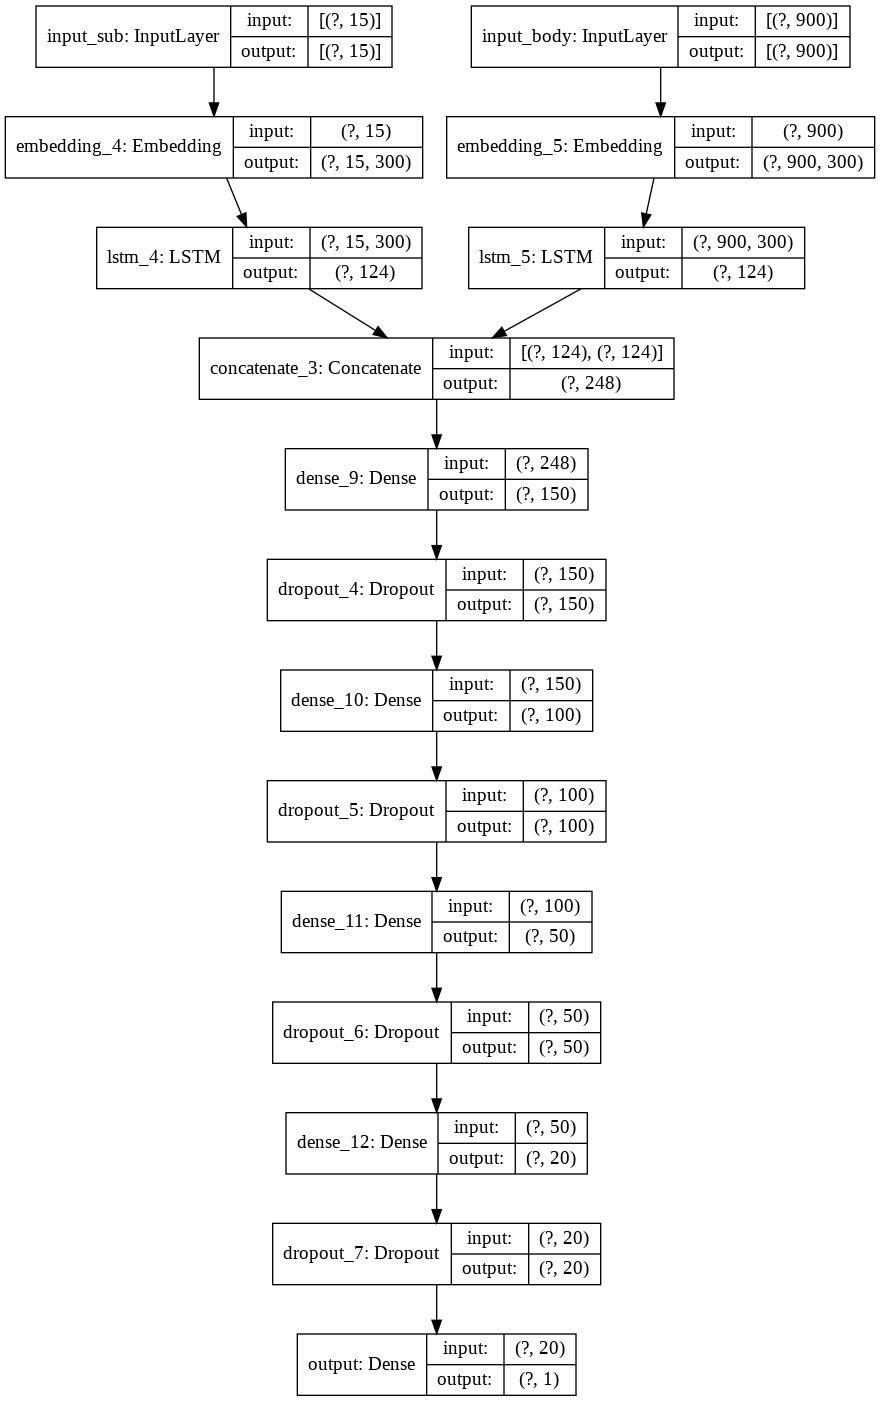

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model_we,show_shapes=True)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
outputFolder = './subscriber_model_output'

if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

filepath=outputFolder+"/weights-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='auto')
earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0.0001, patience=5,
                          verbose=1, mode='auto')

In [0]:
# for Model loaded with last best fit

model_we.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
model_we.fit([sequence_matrix_sub,sequence_matrix_body],y_train.values,validation_data=([sequence_matrix_sub_test,sequence_matrix_body_test],y_test.values),
          epochs=20,batch_size=200,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9993
Epoch 00001: val_accuracy improved from -inf to 0.98812, saving model to ./subscriber_model_output/weights-01-0.9881.h5
133/133 [==============================] - 165s 1s/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0720 - val_accuracy: 0.9881
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9993
Epoch 00002: val_accuracy did not improve from 0.98812
133/133 [==============================] - 160s 1s/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0703 - val_accuracy: 0.9866
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 7.1883e-04 - accuracy: 0.9998
Epoch 00003: val_accuracy improved from 0.98812 to 0.98872, saving model to ./subscriber_model_output/weights-03-0.9887.h5
133/133 [==============================] - 159s 1s/step - loss: 7.1883e-04 - accuracy: 0.9998 - val_loss: 0.0724 - val_accuracy: 0.9887
Epoch 4/20

In [0]:
y_prob=model_we.predict([sequence_matrix_sub,sequence_matrix_body])

In [35]:
print('Train data accuracy',roc_auc_score(y_train,y_prob))
print('Test data accuracy',roc_auc_score(y_test,model_we.predict([sequence_matrix_sub_test,sequence_matrix_body_test])))

Train data accuracy 1.0
Test data accuracy 0.9990551252769889


In [0]:
cutoffs=np.linspace(0.01,0.99,99)
real=y_train
prob_score=y_prob

In [0]:
KS_cut=[]
for cutoff in cutoffs:
  predicted=pd.Series([0]*len(y_train))
  predicted=(prob_score>cutoff).astype(int)
  df=pd.DataFrame(list(zip(y_train,predicted)),columns=["real","predicted"])
  TP=len(df[(df["real"]==1) & (df["predicted"]==1) ])
  FP=len(df[(df["real"]==0) & (df["predicted"]==1) ])
  TN=len(df[(df["real"]==0) & (df["predicted"]==0) ])
  FN=len(df[(df["real"]==1) & (df["predicted"]==0) ])
  P=TP+FN
  N=TN+FP
  KS=(TP/P)-(FP/N)
  KS_cut.append(KS)

cutoff_data=pd.DataFrame(list(zip(cutoffs,KS_cut)),columns=["cutoff","KS"])

KS_cutoff=cutoff_data[cutoff_data["KS"]==cutoff_data["KS"].max()]["cutoff"]

In [38]:
list(KS_cutoff)[0]

0.01

In [39]:
y_predict_test=model_we.predict([sequence_matrix_sub_test,sequence_matrix_body_test])
binary_predict=((y_predict_test>0.01).astype(int))
y_data=pd.DataFrame(binary_predict,columns=['Predicted'])
y_data['Original']=y_test
pd.crosstab(y_data['Original'],y_data['Predicted'])

Predicted,0,1
Original,,
0,3199,48
1,22,3382


In [0]:
# model_we.save(r'/content/gdrive/My Drive/model_we_v2.h5')
# 0.01

In [0]:
#Testing on SPAM Data

In [0]:
spam_mail=pd.read_csv(r'/content/my mail spam.csv?dl=0')

In [0]:
spam=spam_mail.loc[:,['Subject', 'Body']]

In [0]:
spam['Body']=np.where(spam['Body'].isnull(),"nan",spam['Body'])

In [44]:
spam.shape

(413, 2)

In [0]:
import re
string_check= re.compile(r'[@_:.;!#$%^&*()<>?/\|}{~]+-*')
spam['Subject'] = spam['Subject'].apply(lambda x: (" ".join([i for i in x.strip().split() if (string_check.search(i)==None) and ('http' not in i) and ('html' not in i)
          and ('HTML' not in i) and ("=" not in i) and (i not in my_stop) and ("+" not in i) and ("-" not in i) and (len(i)<28)])).strip())

spam['Body'] = spam['Body'].apply(lambda x: (" ".join([i for i in x.strip().split() if (string_check.search(i)==None) and ('http' not in i) and ('html' not in i)
          and ('HTML' not in i) and ("=" not in i) and (i not in my_stop) and ("+" not in i) and ("-" not in i) and (len(i)<28)])).strip())

In [0]:
sequence_spam_mail_sub=tok_sub.texts_to_sequences(spam['Subject'])
seq_spam_mail_sub_matrix=sequence.pad_sequences(sequence_spam_mail_sub,maxlen=max_len_sub)

sequence_spam_mail_body=tok_body.texts_to_sequences(spam['Body'])
seq_spam_mail_body_matrix=sequence.pad_sequences(sequence.pad_sequences(sequence_spam_mail_body,maxlen=max_len_body))

In [0]:
from tensorflow.keras.models import load_model

In [0]:
# model_we=load_model(r'/content/gdrive/My Drive/model_we.h5',custom_objects={'LeakyReLU':LeakyReLU()})

In [0]:
y_spam_mail=model_we.predict([seq_spam_mail_sub_matrix,seq_spam_mail_body_matrix])

In [0]:
y_spam_binary=pd.DataFrame((y_spam_mail>0.01).astype(int),columns=['y_spam_pred'])

In [50]:
y_spam_binary['y_spam_pred'].value_counts()

1    370
0     43
Name: y_spam_pred, dtype: int64

In [0]:
spam['predicted_we']=(y_spam_mail>0.01).astype(int)

In [0]:
#Mail Data

In [59]:
mydata=pd.read_csv(r'/content/my mail.csv?dl=0')

--2020-05-03 13:40:01--  https://www.dropbox.com/s/hmgoihdu8nubzsu/my%20mail.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hmgoihdu8nubzsu/my%20mail.csv [following]
--2020-05-03 13:40:01--  https://www.dropbox.com/s/raw/hmgoihdu8nubzsu/my%20mail.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc47dbfff6375b0352c26b9e3a58.dl.dropboxusercontent.com/cd/0/inline/A3BgD_Y8lAKuBkc5RFfSzmErNdox-APlY53pcPnBH3UO2pF_wEP0_AOzYigy_fgFgNNlKNR-HRU_t9_o_-0quUGDz9yco3rZnAr8E-0MlcYnjvNVBcniWWU4BoHhSeGGVwo/file# [following]
--2020-05-03 13:40:02--  https://uc47dbfff6375b0352c26b9e3a58.dl.dropboxusercontent.com/cd/0/inline/A3BgD_Y8lAKuBkc5RFfSzmErNdox-APlY53pcPnBH3UO2pF_wEP0_AOzYigy_fgFgNNlKNR-HRU_t9_o_-0quUGDz9yco3rZnAr8E-0Mlc

In [0]:
mail=mydata.loc[(mydata['Subject'].notnull()) & (mydata['Body'].notnull()),['Mail_Id','Subject','Body']]
mail.reset_index(drop=True,inplace=True)

In [66]:
mail.shape

(24569, 4)

In [0]:
string_check= re.compile(r'[@_:.;!#$%^&*()<>?/\|}{~]+-*')
mail['Subject'] = mail['Subject'].apply(lambda x: (" ".join([i for i in x.strip().split() if (string_check.search(i)==None) and ('http' not in i) and ('html' not in i)
          and ('HTML' not in i) and ("=" not in i) and (i not in my_stop) and ("+" not in i) and ("-" not in i) and (len(i)<28)])).strip())

mail['Body'] = mail['Body'].apply(lambda x: (" ".join([i for i in x.strip().split() if (string_check.search(i)==None) and ('http' not in i) and ('html' not in i)
          and ('HTML' not in i) and ("=" not in i) and (i not in my_stop) and ("+" not in i) and ("-" not in i) and (len(i)<28)])).strip())

In [0]:
# Mail Subject

sequence_mail_sub=tok_sub.texts_to_sequences(mail['Subject'])
sequence_mail_sub_matrix=sequence.pad_sequences(sequence_mail_sub,maxlen=max_len_sub)

# Mail Body

sequence_mail_body=tok_body.texts_to_sequences(mail['Body'])
sequence_mail_body_matrix=sequence.pad_sequences(sequence_mail_body,maxlen=max_len_body)

In [0]:
#After further training...
y_mail=model_we.predict([sequence_mail_sub_matrix,sequence_mail_body_matrix])

mail['predict_we']=(y_mail>0.01).astype(int)

In [65]:
mail['predict_we'].value_counts()

1    22031
0     2538
Name: predict_we, dtype: int64

In [77]:
mail[mail['predict_we']==0].tail()

,Mail_Id,Subject,Body,predict_we
24560,14cd5287e26a5bba,Team Outing,"On Tue, Jan 6, 2015 AM, Myle Prasen On Mon, Ja...",0
24563,14c87f7e90327ef9,CitiAlert Welcome Citibank,Delivery following recipient failed Technical ...,0
24564,14bf2c5bf23c23b6,Abstract request,"On Wed, Oct 15, 2014 PM, teju reddy",0
24565,14bb21957c90ddb0,BENZ LETTER HEAD,Delivery following recipient failed Technical ...,0
24568,14b34b1222570158,reg project,DEAR VIRENDER SINGH TANWAR GREETINGS FOR THE Y...,0


In [0]:
mail.to_csv(r'/content/Mail Prediction.csv',index=None)

In [0]:
# Initial Model....
y_mail=model_we.predict([sequence_mail_sub_matrix,sequence_mail_body_matrix])

mail['predict_we']=(y_mail>0.06).astype(int)

In [0]:
# mail['predict_we'].value_counts()

1    24569
Name: predict_we, dtype: int64

In [0]:
# TF IDF Check

In [0]:
spam['concate']=spam[['Subject','Body']].apply(lambda x:' '.join(x.astype(str)),axis=1)

In [0]:
spam_tf=tf.transform(spam['concate'])
x_spam_tf=pd.DataFrame(spam_tf.toarray(),columns=tf.get_feature_names())

In [0]:
spam['predict_tf_idf']=(model.predict(x_spam_tf)>0.53).astype(int)

In [0]:
spam['predicted_we'].value_counts()

1    265
0     39
Name: predicted_we, dtype: int64

In [0]:
spam['predict_tf_idf'].value_counts()

1    200
0    104
Name: predict_tf_idf, dtype: int64